In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline

In [3]:
data = pd.read_csv("./Dataset_Melbourne-House-Price/Melbourne_housing_FULL.csv",header=0)

In [4]:
print(data.info())
print(data.describe(include=[object]))
print(data.describe())
print((data.isnull().sum()/len(data)).apply(lambda x: format(x, '.2%')) )
print(data.corr())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
Suburb           34857 non-null object
Address          34857 non-null object
Rooms            34857 non-null int64
Type             34857 non-null object
Price            27247 non-null float64
Method           34857 non-null object
SellerG          34857 non-null object
Date             34857 non-null object
Distance         34856 non-null float64
Postcode         34856 non-null float64
Bedroom2         26640 non-null float64
Bathroom         26631 non-null float64
Car              26129 non-null float64
Landsize         23047 non-null float64
BuildingArea     13742 non-null float64
YearBuilt        15551 non-null float64
CouncilArea      34854 non-null object
Lattitude        26881 non-null float64
Longtitude       26881 non-null float64
Regionname       34854 non-null object
Propertycount    34854 non-null float64
dtypes: float64(12), int64(1), object(8)
memory usage: 5.6+ M

In [5]:
# drop address
data.drop(columns=['Address','Suburb','SellerG','Bedroom2'],inplace=True)

In [6]:
# 1.1 Missing value Processing
# drop the data where price is missing
data.dropna(axis=0, subset=['Price'], inplace=True)
# fill with mode
data.fillna({'Regionname': data['Regionname'].mode()}, inplace=True)
# fill na using back filling
data.fillna(method='bfill', inplace=True)

In [7]:
# 1.2 Categorical value transformation

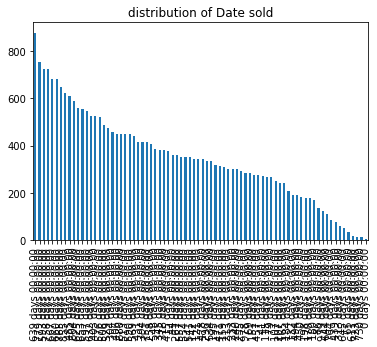

In [8]:
# time data processing
data['Date']=pd.to_datetime(data['Date'])
data['Date']=data['Date']-data['Date'].min()
data['Date'].value_counts().plot.bar(title='distribution of Date sold')
data['Date']=data['Date'].astype("str").str.split().str[0].astype("int")

In [9]:
# get dummies
dum = pd.get_dummies(data)
print(dum.shape)

(27247, 62)


In [10]:
# 1.3 Define X and Y

In [11]:
# normalize X
x_num = data.select_dtypes(include=['number'])
x_num = (x_num - x_num.mean()) / (x_num.std())
x_dummy = pd.get_dummies(data.select_dtypes(exclude=['number']))
x_standard = pd.concat([x_num, x_dummy],axis=1).values

ones = pd.DataFrame({'ones': np.ones(len(x_standard))}).values
X_data = np.hstack([ones, x_standard])

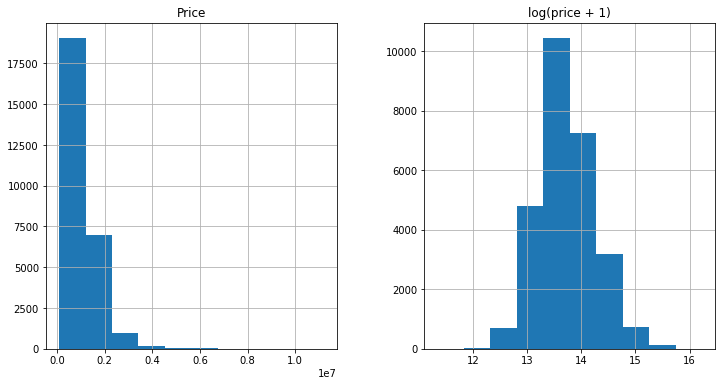

In [13]:
# processing Y
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"Price":data["Price"],
                       "log(price + 1)":np.log1p(data["Price"])})
prices.hist()
y_data = np.log1p(data['Price'].values)
y_data = y_data.reshape(len(y_data), 1)

In [14]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [15]:
# 2. Logistic Regression by tensorflow
# 2.1 Settings
learning_rate = 0.001
training_epochs = 800
display_step = 40

In [71]:
# 2.2 Build the model
# Parameters -- placeholder
tf.reset_default_graph()
X = tf.placeholder(tf.float32, X_data.shape)
y = tf.placeholder(tf.float32, y_data.shape)

W =  tf.get_variable("weights", (X_data.shape[1], 1), initializer=tf.constant_initializer())
y_pred = tf.matmul(X, W)

loss_op = 1 / (2 * len(X_data)) * tf.matmul((y_pred - y), (y_pred - y), transpose_a = True)
opt = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
train_op = opt.minimize(loss_op)

loss_data = []

# Create the session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('./summary/linear-regression-0/', sess.graph)
    for e in range(training_epochs):
        sess.run(train_op, feed_dict = {X: X_data, y: y_data})
        loss, w = sess.run([loss_op, W], feed_dict = {X: X_data, y: y_data})
        loss_data.append(loss)
        if e % display_step == 0:
            log_str = "Epoch %d \t Loss = %.4g \t  Model: y = %.4gx1 + %.4gx2 + %.4g"
            print(log_str % (e, loss, w[1], w[2], w[0]))
        
writer.close()
loss_data = np.array(loss_data).reshape(len(loss_data))

Epoch 0 	 Loss = 93.86 	  Model: y = 0.0002728x1 + 0.0004777x2 + 0.01372
Epoch 10 	 Loss = 89.69 	  Model: y = 0.002899x1 + 0.005139x2 + 0.1492
Epoch 20 	 Loss = 85.7 	  Model: y = 0.005344x1 + 0.009593x2 + 0.2817
Epoch 30 	 Loss = 81.89 	  Model: y = 0.007615x1 + 0.01385x2 + 0.4112
Epoch 40 	 Loss = 78.26 	  Model: y = 0.009717x1 + 0.01791x2 + 0.5378
Epoch 50 	 Loss = 74.8 	  Model: y = 0.01166x1 + 0.02178x2 + 0.6616
Epoch 60 	 Loss = 71.49 	  Model: y = 0.01344x1 + 0.02547x2 + 0.7826
Epoch 70 	 Loss = 68.33 	  Model: y = 0.01508x1 + 0.02898x2 + 0.9009
Epoch 80 	 Loss = 65.32 	  Model: y = 0.01656x1 + 0.03233x2 + 1.016
Epoch 90 	 Loss = 62.44 	  Model: y = 0.01791x1 + 0.03551x2 + 1.13
Epoch 100 	 Loss = 59.69 	  Model: y = 0.01913x1 + 0.03853x2 + 1.24
Epoch 110 	 Loss = 57.07 	  Model: y = 0.02021x1 + 0.0414x2 + 1.348
Epoch 120 	 Loss = 54.57 	  Model: y = 0.02117x1 + 0.04412x2 + 1.454
Epoch 130 	 Loss = 52.18 	  Model: y = 0.02202x1 + 0.04669x2 + 1.557
Epoch 140 	 Loss = 49.9 	  Mode

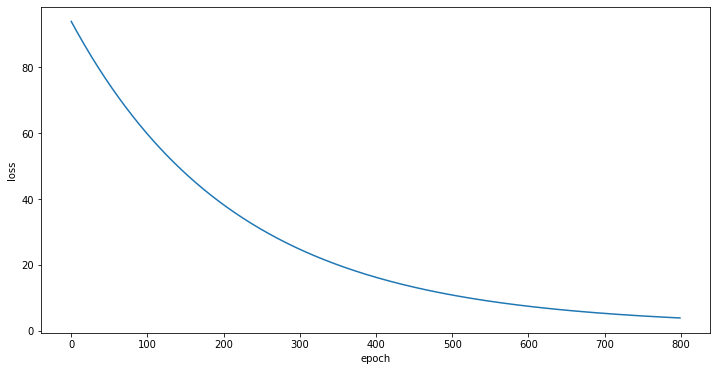

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
# arange支持小数步长
ax = sns.lineplot(x = 'epoch', y = 'loss', data = pd.DataFrame({'loss': loss_data, 'epoch': np.arange(training_epochs)}))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()

In [17]:
# Bayes regression
# Parameters -- placeholder
tf.reset_default_graph()
X = tf.placeholder(tf.float32, X_data.shape)
y = tf.placeholder(tf.float32, y_data.shape)

W=tf.Variable(tf.zeros([X_data.shape[1], 1]), name="weight")
#W =  tf.get_variable("weights", (X_data.shape[1], 1), initializer=tf.constant_initializer())
y_pred = tf.matmul(X, W)


# Prior of W
m0 = np.zeros([X_data.shape[1],1])
S0 = np.identity(X_data.shape[1])
S0 = np.mat(S0)
W_m0 = W - m0

# loss and optimizer (optimizer: IRLS, compute Hessian)
y_pred = tf.matmul(X, W)

loss_op = 0.5 * tf.matmul(tf.matmul(tf.transpose(W_m0), S0.I.astype(np.float32)), W_m0)\
        +1 / (2 * len(X_data)) * tf.matmul((y_pred - y), (y_pred - y), transpose_a = True)
opt = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
train_op = opt.minimize(loss_op)

loss_data = []

# Create the session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('./summary/linear-regression-0/', sess.graph)
    for e in range(training_epochs):
        sess.run(train_op, feed_dict = {X: X_data, y: y_data})
        loss, w = sess.run([loss_op, W], feed_dict = {X: X_data, y: y_data})
        loss_data.append(loss)
        if e % display_step == 0:
            log_str = "Epoch %d \t Loss = %.4g \t  Model: y = %.4gx1 + %.4gx2 + %.4g"
            print(log_str % (e, loss, w[1], w[2], w[0]))
        
writer.close()
loss_data = np.array(loss_data).reshape(len(loss_data))


Epoch 0 	 Loss = 93.86 	  Model: y = 0.0002728x1 + 0.0004777x2 + 0.01372
Epoch 40 	 Loss = 78.88 	  Model: y = 0.009534x1 + 0.01756x2 + 0.5274
Epoch 80 	 Loss = 67.4 	  Model: y = 0.01598x1 + 0.03114x2 + 0.978
Epoch 120 	 Loss = 58.6 	  Model: y = 0.02015x1 + 0.04181x2 + 1.373
Epoch 160 	 Loss = 51.86 	  Model: y = 0.02249x1 + 0.05004x2 + 1.721
Epoch 200 	 Loss = 46.7 	  Model: y = 0.02338x1 + 0.05628x2 + 2.025
Epoch 240 	 Loss = 42.74 	  Model: y = 0.02311x1 + 0.06086x2 + 2.293
Epoch 280 	 Loss = 39.7 	  Model: y = 0.02195x1 + 0.06409x2 + 2.528
Epoch 320 	 Loss = 37.37 	  Model: y = 0.02011x1 + 0.06621x2 + 2.735
Epoch 360 	 Loss = 35.58 	  Model: y = 0.01777x1 + 0.06745x2 + 2.916
Epoch 400 	 Loss = 34.21 	  Model: y = 0.01507x1 + 0.06797x2 + 3.076
Epoch 440 	 Loss = 33.16 	  Model: y = 0.01212x1 + 0.06792x2 + 3.217
Epoch 480 	 Loss = 32.35 	  Model: y = 0.009019x1 + 0.06743x2 + 3.34
Epoch 520 	 Loss = 31.73 	  Model: y = 0.005845x1 + 0.0666x2 + 3.449
Epoch 560 	 Loss = 31.25 	  Model:

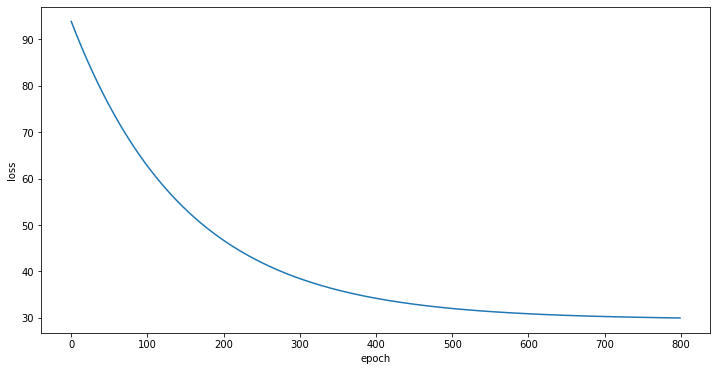

In [18]:
ax = sns.lineplot(x = 'epoch', y = 'loss', data = pd.DataFrame({'loss': loss_data, 'epoch': np.arange(training_epochs)}))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()